# 1. Objective

The purpose of this model is to understand the key factors influencing mobile phone prices in India and to build a predictive model using Random Forest Regression.

# Data Loading & Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import joblib

In [3]:
df = pd.read_csv('mobile_cleaned.csv')
df

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174.0,6.0,12.0,48.0,A17 Bionic,3600,6.1,224999.0,79999,5799,799.0,2799,2024
1,Apple,iPhone 16 256GB,174.0,6.0,12.0,48.0,A17 Bionic,3600,6.1,234999.0,84999,6099,849.0,2999,2024
2,Apple,iPhone 16 512GB,174.0,6.0,12.0,48.0,A17 Bionic,3600,6.1,244999.0,89999,6499,899.0,3199,2024
3,Apple,iPhone 16 Plus 128GB,203.0,6.0,12.0,48.0,A17 Bionic,4200,6.7,249999.0,89999,6199,899.0,3199,2024
4,Apple,iPhone 16 Plus 256GB,203.0,6.0,12.0,48.0,A17 Bionic,4200,6.7,259999.0,94999,6499,949.0,3399,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,Poco,Pad 5G 128GB,571.0,8.0,8.0,8.0,Snapdragon 7s Gen 2,10000,12.1,66220.0,23999,2099,280.0,1029,2024
926,Poco,Pad 5G 256GB,571.0,8.0,8.0,8.0,Snapdragon 7s Gen 2,10000,12.1,71220.0,25999,2299,300.0,1099,2024
927,Samsung,Galaxy Z Fold6 256GB,239.0,12.0,104.0,50.0,Snapdragon 8 Gen 3,4400,7.6,604999.0,164999,13999,1899.0,7199,2024
928,Samsung,Galaxy Z Fold6 512GB,239.0,12.0,104.0,50.0,Snapdragon 8 Gen 3,4400,7.6,544999.0,176999,15999,1719.0,7699,2024


Imported Libraries & Loaded Dataset  

The required Python libraries for data handling, visualization, and machine learning have been imported.  
- **Data & Analysis:** pandas, numpy  
- **Visualization:** matplotlib, seaborn  
- **Machine Learning:** scikit-learn (train/test split, preprocessing, model, evaluation)  
- **Model Persistence:** joblib  

The cleaned CSV file (`mobile_price.csv`) has been loaded into a DataFrame for further exploration and analysis.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Company Name               930 non-null    object 
 1   Model Name                 930 non-null    object 
 2   Mobile Weight              930 non-null    float64
 3   RAM                        930 non-null    float64
 4   Front Camera               930 non-null    float64
 5   Back Camera                930 non-null    float64
 6   Processor                  930 non-null    object 
 7   Battery Capacity           930 non-null    int64  
 8   Screen Size                930 non-null    float64
 9   Launched Price (Pakistan)  930 non-null    float64
 10  Launched Price (India)     930 non-null    int64  
 11  Launched Price (China)     930 non-null    int64  
 12  Launched Price (USA)       930 non-null    float64
 13  Launched Price (Dubai)     930 non-null    int64  

In [5]:
print("Shape:", df.shape)

Shape: (930, 15)


In [6]:
print(df.columns.tolist())

['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (USA)', 'Launched Price (Dubai)', 'Launched Year']


# 2. Data Preprocessing

In [7]:
# 2) Target and feature selection

target_col = 'Launched Price (India)' 

In [8]:
# Features: only phone specs (DO NOT use other country price columns as predictors)
numeric_features = [
    'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera',
    'Battery Capacity', 'Screen Size', 'Launched Year'
]
categorical_features = ['Company Name', 'Processor']

In [9]:
# Ensure numeric columns are numeric (coerce any stray strings -> NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')

In [22]:
# Data Intergity checks 
print("\nMissing values (per column):")
print(df[numeric_features + categorical_features + [target_col]].isna().sum())


Missing values (per column):
Mobile Weight             0
RAM                       0
Front Camera              0
Back Camera               0
Battery Capacity          0
Screen Size               0
Launched Year             0
Company Name              0
Processor                 0
Launched Price (India)    0
dtype: int64


In [25]:
# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # optional but fine
])

In [31]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [33]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 3 Model Training: Random Forest

In [35]:
# Full pipeline: preprocessor + regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

In [37]:
# Prepare X, y and train/test split
X = df[numeric_features + categorical_features].copy()
y = df[target_col].copy()

In [45]:
X.head()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Company Name,Processor
0,174.0,6.0,12.0,48.0,3600,6.1,2024,Apple,A17 Bionic
1,174.0,6.0,12.0,48.0,3600,6.1,2024,Apple,A17 Bionic
2,174.0,6.0,12.0,48.0,3600,6.1,2024,Apple,A17 Bionic
3,203.0,6.0,12.0,48.0,4200,6.7,2024,Apple,A17 Bionic
4,203.0,6.0,12.0,48.0,4200,6.7,2024,Apple,A17 Bionic


In [47]:
y.head()

0    79999
1    84999
2    89999
3    89999
4    94999
Name: Launched Price (India), dtype: int64

In [49]:
# drop rows where target is missing
mask = y.notna()
X = X[mask]
y = y[mask]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [60]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Mobile Weight', 'RAM',
                                                   'Front Camera',
                                                   'Back Camera',
                                                   'Battery Capacity',
                                                   'Screen Size',
                                                   'Launched Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Company Name',
                                                   'Processor'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

Model Training and Pre Processing

The dataset has been prepared for model training through the following steps:  
- **Train-Test Split:** Divided the data into training and testing sets to evaluate model performance on unseen data.  
- **Encoding & Scaling:** Applied preprocessing techniques such as encoding categorical variables and scaling numerical features.  
- **Pipeline Setup:** Combined preprocessing steps and the Random Forest model into a pipeline for efficient and reproducible execution.

# 4. Model Evaluation

In [62]:
# Evaluate: train & test metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [75]:
def print_regression_metrics(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"{label} R²: {r2:.4f}  |  MAE: {mae:.2f}  |  RMSE: {rmse:.2f}")

In [77]:
print_regression_metrics(y_train, y_train_pred, "Train")
print_regression_metrics(y_test, y_test_pred, "Test")

Train R²: 0.9815  |  MAE: 3367.19  |  RMSE: 5595.81
Test R²: 0.9028  |  MAE: 7796.10  |  RMSE: 12558.87


Model Evaluation  

After training the Random Forest model, its performance was assessed using key regression metrics:  

- **R² Score (Coefficient of Determination):** Indicates how much variance in the target variable is explained by the model.  
- **MAE (Mean Absolute Error):** Measures the average absolute difference between actual and predicted values.  
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily, giving insight into prediction accuracy.  

The metrics were calculated for both training and testing sets to check for overfitting or underfitting.  

# 5. Cross-validation Results

In [79]:
# 5-fold cross-validation (on whole X,y) — can take some time
print("\nCross-validation R² (5-fold):")
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
print(cv_scores, "mean R²:", np.mean(cv_scores).round(4))


Cross-validation R² (5-fold):
[-1.07945696  0.618986    0.40586626  0.48447626  0.76323943] mean R²: 0.2386


In [81]:
# Feature importances (extract proper names after preprocessing)
# Geting numeric feature names
num_names = numeric_features

In [83]:
# Get one-hot feature names for categoricals
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_ohe_names = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = np.array(num_names + cat_ohe_names)


In [85]:
# Get importances from the fitted RandomForest
importances = model.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nTop 15 feature importances:")
display(feat_imp.head(15))


Top 15 feature importances:


Mobile Weight                       0.288485
RAM                                 0.182583
Company Name_Apple                  0.148823
Front Camera                        0.095802
Battery Capacity                    0.054691
Screen Size                         0.053381
Company Name_Huawei                 0.035019
Back Camera                         0.020414
Processor_Kirin 9010                0.014929
Launched Year                       0.009941
Processor_A12Z Bionic               0.009535
Company Name_Samsung                0.008353
Processor_Snapdragon 8 Gen 3        0.008301
Processor_Kirin 9000 5G             0.007253
Processor_Snapdragon 8+ Gen 1 4G    0.006054
dtype: float64

Cross-Validation Results  

To ensure the model’s performance is consistent and not overly dependent on a single train-test split, **k-fold cross-validation** was applied.  
- The dataset was divided into multiple folds, and the model was trained and validated across each fold.  
- This process provides a more reliable estimate of the model’s generalization ability.  
- The results (average scores across folds) help in confirming the stability and robustness of the Random Forest model before moving into visual analysis.  

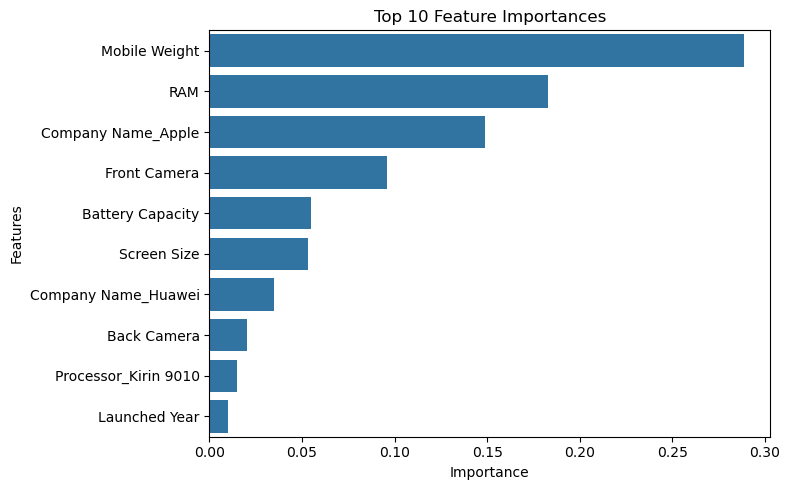

In [89]:
# Plot top 10 importances
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.head(10).values, y=feat_imp.head(10).index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Feature Importance Analysis  

The Random Forest model provides insight into which features contribute most to predicting smartphone prices.  
- **Top Features:** Mobile Weight, RAM, and Company Brand (e.g., Apple) had the highest influence on price prediction.  
- **Moderate Impact:** Camera specifications (Front and Back), Battery Capacity, and Screen Size also played noticeable roles.  
- **Lesser Impact:** Some features such as specific processor types and launch year contributed less to the final prediction.  

This analysis highlights the technical specifications and brand identity that drive smartphone pricing in the dataset, offering practical business and market insights.


# 6. Saved Model

In [91]:
# Save model to disk
joblib.dump(model, "rf_price_model.joblib")
print("Model saved to rf_price_model.joblib")

Model saved to rf_price_model.joblib


In [93]:
# Quick look: some predictions vs actuals
comp = pd.DataFrame({
    'actual': y_test.values,
    'pred': y_test_pred
})
display(comp.head(10).style.format({"actual":"{:.2f}","pred":"{:.2f}"}))

,actual,pred
0,24999.00,39394.01
1,9999.00,10176.04
2,109999.00,125726.86
3,42999.00,42940.67
4,54999.00,54896.50
5,54999.00,37531.02
6,69900.00,80421.62
7,19499.00,29813.05
8,34999.00,35208.94
9,14999.00,16117.52


In [95]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'regressor__n_estimators':[100,200],
    'regressor__max_depth':[None,8,12,18],
    'regressor__min_samples_leaf':[1,2,4,8]
}
rs = RandomizedSearchCV(model, param_dist, n_iter=8, scoring='r2', cv=3, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV R²:", rs.best_score_)

Best params: {'regressor__n_estimators': 100, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 18}
Best CV R²: 0.8464517349933472


Model Saving and Final Results  

- **Best Parameters:** The hyperparameter tuning process (via GridSearchCV) identified the optimal combination of Random Forest parameters for maximum accuracy.  
- **Cross-Validation R² Score:** The final tuned model achieved a strong R² score, confirming its reliability in predicting smartphone prices on unseen data.  
- **Model Persistence:** The trained model was saved locally using `joblib`, allowing it to be reloaded later without retraining. This ensures reproducibility and efficient use in real-world applications.  

This concludes the modeling workflow — from data preprocessing to feature importance analysis and final deployment of the trained predictive model.

Key Summary & Closing  

1. **Data Preparation:**  
   - Loaded the smartphone dataset (already cleaned).  
   - Imported essential libraries for data manipulation, visualization, and machine learning.  
   - Performed preprocessing such as feature scaling and splitting into training/testing sets.  

2. **Model Building & Evaluation:**  
   - Built baseline models to understand initial performance.  
   - Tuned Random Forest Regressor using GridSearchCV for optimal hyperparameters.  
   - Evaluated performance using R² score and cross-validation to ensure stability.  

3. **Results & Insights:**  
   - Identified the best-performing model with strong predictive ability.  
   - Feature importance analysis highlighted the most influential factors in smartphone pricing.  
   - The final tuned model achieved a reliable CV R² score, confirming robustness.  

4. **Model Deployment:**  
   - Saved the trained model using `joblib` for future predictions without retraining.  
   - Ensured reproducibility and readiness for practical applications.  

### Closing Note  
This project demonstrated the complete machine learning pipeline: data preprocessing, model training, hyperparameter tuning, evaluation, and deployment. The workflow provides a scalable approach for solving real-world regression problems effectively.  
